In [6]:
#zadanie 1
# @title Upload local HTML
from google.colab import files
uploaded = files.upload()   # wybierz training_cars.html
list(uploaded.keys())       # podgląd nazw wgranych plików


[]

In [7]:
# @title Parse Exercise 1
from bs4 import BeautifulSoup
from urllib.parse import urljoin

BASE = "https://automarket.example.com"

# Jeśli nazwa pliku jest inna niż 'training_cars.html', zmień poniżej:
HTML_FILENAME = "training_cars.html"

# 1) wczytaj plik
with open(HTML_FILENAME, "r", encoding="utf-8") as f:
    html = f.read()

soup = BeautifulSoup(html, "html.parser")

# 2) policz karty aut
cars = soup.select("ul.car-list > li.car")
print("Liczba aut:", len(cars))

# 3) breadcrumbs
crumbs = [a.get_text(strip=True) for a in soup.select(".breadcrumbs a")]
print("Breadcrumbs:", " > ".join(crumbs))

# 4) podstawowe pola
for li in cars:
    sku = li.get("data-sku")
    seg = li.get("data-seg")
    a = li.select_one(".name a")
    name = a.get_text(strip=True) if a else None
    url = urljoin(BASE, a["href"]) if a and a.has_attr("href") else None
    print(f"- {sku} | {seg} | {name} | {url}")


Liczba aut: 4
Breadcrumbs: Motoryzacja > Samochody
- C100 | compact | CityGo 1.0 | https://automarket.example.com/p/C100
- C200 | crossover | CrossX 1.5T | https://automarket.example.com/p/C200
- C300 | sedan | Elegance 2.0 | https://automarket.example.com/p/C300
- C400 | ev | Volt E | https://automarket.example.com/p/C400


In [8]:
# @title Optional: Pandas table
import pandas as pd
from urllib.parse import urljoin

rows = []
for li in cars:
    a = li.select_one(".name a")
    rows.append({
        "sku": li.get("data-sku"),
        "segment": li.get("data-seg"),
        "name": a.get_text(strip=True) if a else None,
        "url": urljoin(BASE, a["href"]) if a and a.has_attr("href") else None,
    })

df = pd.DataFrame(rows)
df  # wyświetli tabelę


,sku,segment,name,url
0,C100,compact,CityGo 1.0,https://automarket.example.com/p/C100
1,C200,crossover,CrossX 1.5T,https://automarket.example.com/p/C200
2,C300,sedan,Elegance 2.0,https://automarket.example.com/p/C300
3,C400,ev,Volt E,https://automarket.example.com/p/C400


In [16]:
import re
def normalize_number_text(num_txt: str) -> str:
    # usuń spacje tysięcy; przecinek na kropkę (134,500 -> 134.500; 179.990 zostaje 179.990)
    return num_txt.replace(" ", "").replace(",", ".")

_price_num_re = re.compile(r"(\d+(?:[.,]\d+)?)")

def parse_price_to_float(txt):
    if not txt:
        return None
    txt = normalize_number_text(txt)
    m = _price_num_re.search(txt)
    if not m:
        return None
    try:
        return float(m.group(1).replace(",", "."))
    except ValueError:
        return None

def extract_stock(li) -> int | None:
    txt = li.select_one(".availability")
    t = txt.get_text(" ", strip=True) if txt else ""
    m = re.search(r"\((\d+)\)", t)
    if m:
        return int(m.group(1))
    if ("out" in (txt.get("class", []) if txt else [])) or ("niedostępne" in t.lower()):
        return 0
    return None

# # --- load soup ---
# with open(HTML_FILENAME, "r", encoding="utf-8") as f:
#     html = f.read()
# soup = BeautifulSoup(html, "html.parser")

# --- parse cards ---
cars = soup.select("ul.car-list > li.car")
print("Liczba aut:", len(cars))

rows = []
for li in cars:
    # wybór ceny końcowej
    promo = li.select_one(".prices .price.promo")
    base  = li.select_one(".prices .price:not(.promo):not(.old)")
    old = li.select_one(".prices .price.old")

    raw_promo   = promo.get_text(strip=True) if promo else None
    raw_base  = base.get_text(strip=True) if base else None
    raw_old  = old.get_text(strip=True) if old else None

    price_promo = parse_price_to_float(raw_promo)
    price_base = parse_price_to_float(raw_base)
    price_old = parse_price_to_float(raw_old)

    price = price_promo if price_promo is not None else price_base
    stock = extract_stock(li)

    sku = li.get("data-sku")
    name_tag = li.select_one(".name a")
    name = name_tag.get_text(strip=True) if name_tag else None

    discount_pct = None
    if price_old is not None and price is not None and price_old > 0:
      discount_pct = (price_old - price) / price_old * 100


    print(f"- {sku}: price_raw={raw_promo!r} -> {price}, stock={stock}")
    rows.append({"sku": sku, "name": name, "price_raw": raw_promo or raw_base, "price": price, "stock": stock, "old_raw": raw_old, "promo_raw": raw_promo, "old": price_old, "promo": price_promo, "discount_pct": discount_pct})


# statystyki
in_stock_prices = [r["price"] for r in rows if (r["stock"] or 0) > 0 and r["price"] is not None]
avg_price = round(sum(in_stock_prices)/len(in_stock_prices), 2) if in_stock_prices else None
zero_stock = sum(1 for r in rows if r["stock"] == 0)

print("\nŚrednia cena (dla aut z dostępnością > 0):", avg_price)
print("Liczba aut z zerowym stanem:", zero_stock)

Liczba aut: 4
- C100: price_raw=None -> 62900.0, stock=5
- C200: price_raw='PLN 109 900' -> 109900.0, stock=2
- C300: price_raw=None -> 134.5, stock=0
- C400: price_raw=None -> 179.99, stock=0

Średnia cena (dla aut z dostępnością > 0): 86400.0
Liczba aut z zerowym stanem: 2


,sku,name,old_raw,promo_raw,discount_pct
0,C100,CityGo 1.0,None,None,NaN
1,C200,CrossX 1.5T,PLN 119 900,PLN 109 900,8.340284
2,C300,Elegance 2.0,None,None,NaN
3,C400,Volt E,None,None,NaN


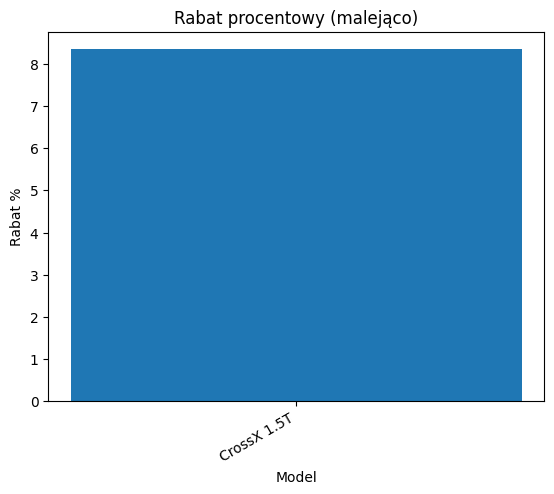

In [17]:
# @title Optional: pandas table + bar chart
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(rows)
display(df[["sku","name","old_raw","promo_raw","discount_pct"]])

# prosty wykres słupkowy rabatów (tylko rekordy z rabatem)
dfp = df.dropna(subset=["discount_pct"]).copy()
if not dfp.empty:
    dfp = dfp.sort_values("discount_pct", ascending=False)
    plt.figure()
    plt.bar(dfp["name"], dfp["discount_pct"])
    plt.title("Rabat procentowy (malejąco)")
    plt.xlabel("Model")
    plt.ylabel("Rabat %")
    plt.xticks(rotation=30, ha="right")
    plt.show()
else:
    print("Brak pozycji z rabatem.")
